# Model for AFM Image Coverage From Scratch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms


import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import *
from matplotlib import  style


import time
import os
import copy
import random


import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torch.utils.data import DataLoader, TensorDataset

import json
import pickle


import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score  
from sklearn.metrics import mean_squared_error as mse

from timeit import default_timer as timer



from codes.utils_coverage import CustomImageDataset, grouped_train_test_split, model_inference, coverage_models_inference



torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
batch_size = 100

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [2]:
print(torch.cuda.mem_get_info(device=None))

(25055854592, 25438126080)


In [2]:
with open("Data/WSe2_sample_labels", "rb") as fp:   #Pickling
   data_sample_labels = pickle.load(fp)

train_group = data_sample_labels['train']
val_group = data_sample_labels['val']
test_group = data_sample_labels['test']

In [5]:


# Specify the path to your dataset folder
# root_dir = 'patches_2023-09-14'
#root_dir = '/noether/s0/wfr5091/wse2/2023-09-15_n5'
root_dir = 'Data/WSe2_micrographs'


transform_test = transforms.Compose([
      #transforms.ToPILImage(),

      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])

batch_size = 8
def data_feeder(batch_size):
    transform = transforms.Compose([
      #transforms.ToPILImage(),
      transforms.RandomRotation(degrees= (0, 180)),
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomVerticalFlip(0.5),
      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])
   
    custom_dataset = CustomImageDataset(root_dir, transform=transform, max_index=None)

    train_dataset, val_dataset, test_dataset = grouped_train_test_split(train_group, val_group, test_group,custom_dataset, test_size=0.1, random_state=0)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    return train_dataloader, val_dataloader, test_dataloader
train_dataloader, val_dataloader, test_dataloader = data_feeder(batch_size) 

In [6]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.conv3 = nn.Conv2d(16, 8, 5)
        self.conv4 = nn.Conv2d(8, 4, 5)
        self.fc1 = nn.Linear(4 * 10 * 10, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)
        #self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print('shape.x', x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


model = Net().to(device)

input = torch.randn(16, 1, 224, 224).to(device)
input.to(device)
#print(input.shape)
output = model(input)
output.shape

torch.Size([16, 1])

In [7]:

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#mae = nn.L1Loss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.000225)#, 0.000225weight_decay = 0.0001) # 0.005 was used in the saved model I 

In [8]:
#print(inputs[:, 0, :, :].shape)

print(inputs.shape)

torch.Size([8, 224, 224])


In [8]:

start = timer()


running_loss_list = []
val_running_loss_list = []
mean_abs_error_list = []
val_mean_abs_error_list = []


performance_record = {'train': {'loss': [], 'mae': []}, 'val': {'val_loss': [], 'val_mae': []}}
for epoch in range(1, 5501):  # loop over the dataset multiple times  3001th
          
    true_train = []
    pred_train = []

    true_val = []
    pred_val = []    
  
    #model_micro.train()
    for inputs, labels, groups in train_dataloader:
    
        
        inputs, labels = inputs[:,0, :, :].float().unsqueeze(1).to(device), labels.float().unsqueeze(1).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward  + optimize

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        true_train += labels.cpu().tolist()
        pred_train += outputs.cpu().tolist()
      


    #model_micro.eval()
    with torch.no_grad():
        for inputs, labels, groups in val_dataloader:

            inputs, labels = inputs[:, 0, :, :].float().unsqueeze(1).to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            true_val += labels.cpu().tolist()
            pred_val += outputs.cpu().tolist()

    train_mae = mae(true_train, pred_train)
    train_rmse = np.sqrt(mse(true_train,pred_train))
    
    val_mae = mae(true_val, pred_val)
    val_rmse = np.sqrt(mse(true_val,pred_val))
    
    
      
    running_loss_list.append(float(f'{train_rmse:.4f}'))
    val_running_loss_list.append(float(f'{val_rmse:.4f}'))
    mean_abs_error_list.append(float(f'{train_mae:.4f}'))
    val_mean_abs_error_list.append(float(f'{val_mae:.4f}'))
    print(f'Epoch{epoch}: rmse: {train_rmse:.4f} val_rmse: {val_rmse :.4f}, mae: {train_mae:.4f} val_mae: {val_mae:.4f}')
    
    if train_mae <= 0.03 and val_mae <= 0.023:#0.023 achieved
        break
performance_record['train']['loss'] += running_loss_list
performance_record['train']['mae'] += mean_abs_error_list
performance_record['val']['val_loss'] += val_running_loss_list
performance_record['val']['val_mae']  += val_mean_abs_error_list


end = timer()
print((end - start)/3600)

Epoch1: rmse: 0.3248 val_rmse: 0.2867, mae: 0.2758 val_mae: 0.2574
Epoch2: rmse: 0.2905 val_rmse: 0.2784, mae: 0.2482 val_mae: 0.2393
Epoch3: rmse: 0.2852 val_rmse: 0.2689, mae: 0.2402 val_mae: 0.2307
Epoch4: rmse: 0.2775 val_rmse: 0.2671, mae: 0.2315 val_mae: 0.2252
Epoch5: rmse: 0.2773 val_rmse: 0.2678, mae: 0.2304 val_mae: 0.2170
Epoch6: rmse: 0.2745 val_rmse: 0.2661, mae: 0.2271 val_mae: 0.2169
Epoch7: rmse: 0.2696 val_rmse: 0.2626, mae: 0.2210 val_mae: 0.2091
Epoch8: rmse: 0.2706 val_rmse: 0.2552, mae: 0.2207 val_mae: 0.2073
Epoch9: rmse: 0.2623 val_rmse: 0.2349, mae: 0.2130 val_mae: 0.2028
Epoch10: rmse: 0.1750 val_rmse: 0.1632, mae: 0.1229 val_mae: 0.1240
Epoch11: rmse: 0.1454 val_rmse: 0.1369, mae: 0.0946 val_mae: 0.0768
Epoch12: rmse: 0.1348 val_rmse: 0.1332, mae: 0.0859 val_mae: 0.0754
Epoch13: rmse: 0.1361 val_rmse: 0.1538, mae: 0.0858 val_mae: 0.1068
Epoch14: rmse: 0.1328 val_rmse: 0.1290, mae: 0.0838 val_mae: 0.0772
Epoch15: rmse: 0.1358 val_rmse: 0.1336, mae: 0.0867 val_m

In [20]:
with open("Models/performance_scratch_sample", "wb") as fp:   #Pickling
  pickle.dump(performance_record, fp)
  
# to save model
PATH = 'Models/model_scratch_sample.pth'
torch.save(model.state_dict(), PATH)


In [10]:
# specify path
PATH = "Models/model_scratch_sample.pth"
# to load model

#model = model_micro()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
with open("Models/performance_scratch_sample", "rb") as fp:   #Pickling
   performance_scratch = pickle.load(fp)
  

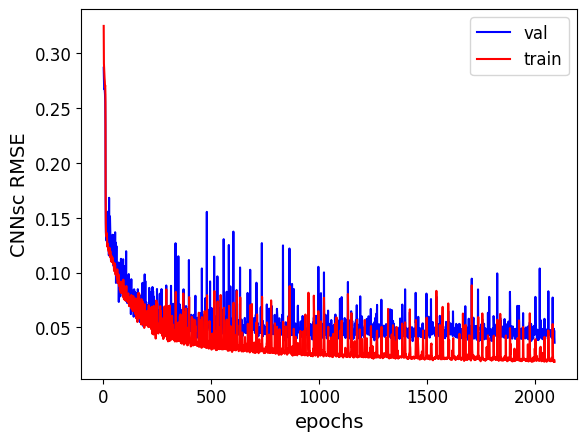

In [22]:

#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings


history_dict = performance_scratch
loss_values = history_dict['train']['loss']
val_loss_values = history_dict['val']['val_loss']

acc_values = history_dict['train']['mae']
val_acc_values = history_dict['val']['val_mae']
epochs = range(1, len(acc_values) + 1)
N = 200



fig, ax1 = plt.subplots()
rc('axes', linewidth=1.2)
#plt.rcParams['font.size'] = '12'
#plt.rcParams['font.weight'] = 'bold'
#plt.rcParams['font.style'] = 'italic'
plt.xlabel('epochs', fontsize=14)
plt.ylabel('CNNsc RMSE', fontsize=14)

#plt.style.use("bmh")

#plt.rcParams.update({'figure.figsize': (12.0, 8.0)})


left, bottom, width, height = [0.39, 0.55, 0.5, 0.32]


ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, 'b', label = 'val')
ax1.plot(range(1, len(loss_values) + 1), loss_values, 'r', label = 'train')

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#ax1.grid(axis='y')


plt.legend()

plt.savefig("Results/scratch_coverage_loss_sample.png", dpi=600)
plt.show()

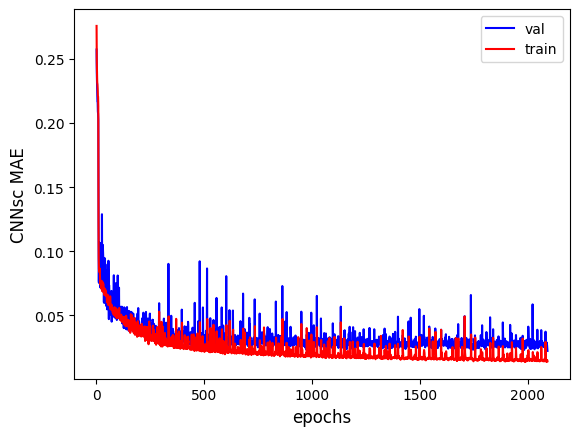

In [23]:

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

history_dict = performance_scratch
loss_values = history_dict['train']['loss']
val_loss_values = history_dict['val']['val_loss']

acc_values = history_dict['train']['mae']
val_acc_values = history_dict['val']['val_mae']
epochs = range(1, len(acc_values) + 1)
N = 200



fig, ax1 = plt.subplots()
rc('axes', linewidth=1.5)
#plt.rcParams['font.size'] = '12'
#plt.rcParams['font.weight'] = 'bold'
#plt.rcParams['font.style'] = 'italic'
plt.xlabel('epochs', fontsize=12)
plt.ylabel('CNNsc MAE', fontsize=12)

#plt.style.use("bmh")

#plt.rcParams.update({'figure.figsize': (12.0, 8.0)})

left, bottom, width, height = [0.39, 0.55, 0.5, 0.32]

ax1.plot(range(1, len(val_loss_values) + 1), val_acc_values, 'b', label = 'val')
ax1.plot(range(1, len(loss_values) + 1), acc_values, 'r', label = 'train')



#ax1.grid(axis='y')

plt.legend()

plt.savefig("Results/scratch_coverage_mae_sample.png", dpi=600)
plt.show()

In [24]:
def data_feeder(batch_size):
    transform = transforms.Compose([
      #transforms.ToPILImage(),
      #transforms.RandomRotation(degrees= (0, 180)),
      #transforms.RandomHorizontalFlip(0.5),
      #transforms.RandomVerticalFlip(0.5),
      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      #transforms.Normalize(mean=mean, std=std),
        ])
   
    custom_dataset = CustomImageDataset(root_dir, transform=transform, max_index=None)

    train_dataset, val_dataset, test_dataset = grouped_train_test_split(custom_dataset, test_size=0.1, random_state=0)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    return train_dataloader, val_dataloader, test_dataloader
train_dataloader, val_dataloader, test_dataloader = data_feeder(batch_size) 

In [25]:

def model_inference(model, dataloader):
    model.eval()
    true_label = []
    pred_label = []

    with torch.no_grad():
        for inputs, labels, groups in dataloader:

            inputs, labels = inputs[:, 0, :, :].float().unsqueeze(1).to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)


            true_label += labels.cpu().tolist()
            pred_label += outputs.cpu().tolist()

        pred_mae = mae(true_label, pred_label)
        pred_rmse = np.sqrt(mse(true_label,pred_label))
        
    return true_label, pred_label, pred_mae, pred_rmse

In [26]:
true_test, pred_test, test_mae, test_rmse = model_inference(model, test_dataloader)

print(test_mae)
print(test_rmse)

0.028785311592661816
0.04104566087232469


In [27]:
true_val, pred_val, val_mae, val_rmse = model_inference(model, val_dataloader)

print(val_mae)
print(val_rmse)

0.023525526295557167
0.03929009740261691


In [28]:
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

true_train, pred_train, train_mae, train_rmse = model_inference(model, train_dataloader)

print(train_mae)
print(train_rmse)

0.013199893640011694
0.01814514054354204


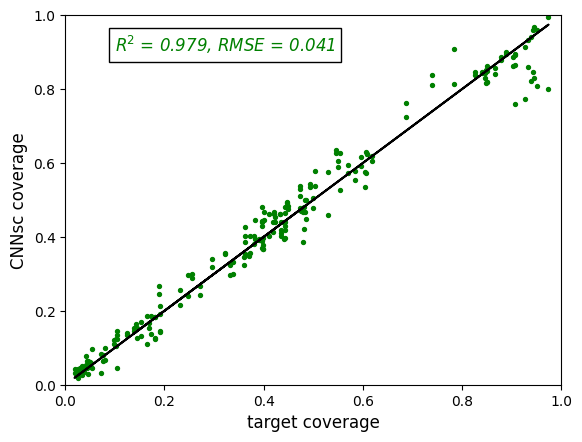

In [29]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

test_r2_score = r2_score(true_test, pred_test)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNNsc coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.1
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {test_r2_score:.3f}, RMSE = {test_rmse:.3f}', style='italic', color = 'g', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.scatter(true_test, pred_test, color = 'g', s=8)

plt.plot(true_test, true_test, 'black')

plt.savefig("Results/scratch_coverage_test_sample.png", dpi=600)
plt.savefig("Results/scratch_coverage_test_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


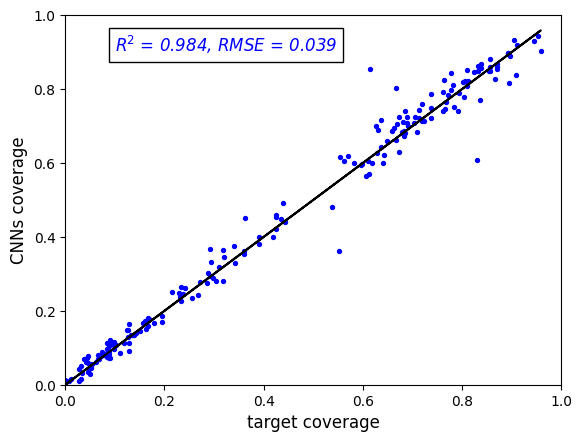

In [30]:
#Val

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings


val_r2_score = r2_score(true_val, pred_val)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNNs coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.1
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {val_r2_score:.3f}, RMSE = {val_rmse:.3f}', style='italic', color = 'b', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.scatter(true_val, pred_val, color = 'b', s=8)

plt.plot(true_val, true_val, 'black')

plt.savefig("Results/scratch_coverage_val_sample.png", dpi=600)
plt.savefig("Results/scratch_coverage_val_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


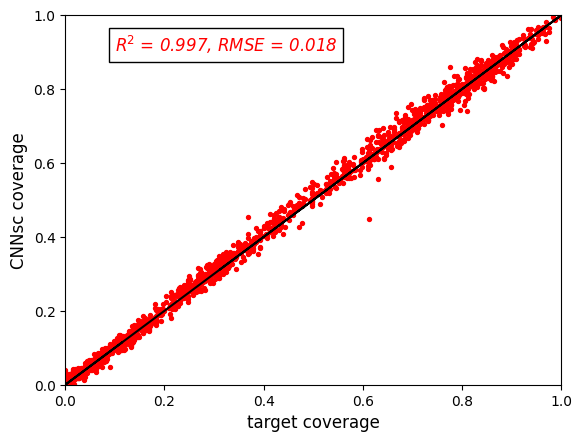

In [31]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

train_r2_score = r2_score(true_train, pred_train)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNNsc coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.1
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {train_r2_score:.3f}, RMSE = {train_rmse:.3f}', style='italic', color = 'r', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


plt.scatter(true_train, pred_train, color = 'r', s=8)

plt.plot(true_train, true_train, 'black')

plt.savefig("Results/scratch_coverage_train_sample.png", dpi=600)
plt.savefig("Results/scratch_coverage_train_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()


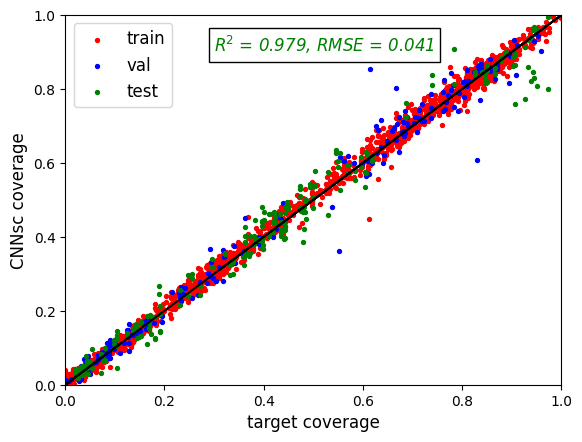

In [32]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

fig, ax1 = plt.subplots()

#rc('axes', linewidth=1.2)
plt.rcParams['font.size'] = '12'


train_r2_score = r2_score(true_train, pred_train)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('CNNsc coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.3
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {test_r2_score:.3f}, RMSE = {test_rmse:.3f}', style='italic', color = 'g', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


ax1.scatter(true_train, pred_train, color = 'r', s=8, label='train')
ax1.scatter(true_val, pred_val, color = 'b', s=8, label='val')
ax1.scatter(true_test, pred_test, color = 'g', s=8, label='test')
ax1.plot(true_train, true_train, 'black')
plt.legend()
plt.savefig("Results/scratch_coverage_train_val_test_sample.png", dpi=600)
plt.savefig("Results/scratch_coverage_train_val_test_sample.pdf", format="pdf", bbox_inches="tight")
plt.show()
